In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile

zip_path = "/content/drive/MyDrive/image_tensors.zip"
extract_path = "data"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

In [3]:
import os
import torch
from torch.utils.data import Dataset


class PTImageFlatDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for fname in os.listdir(root_dir):
            if fname.endswith(".pt"):
                path = os.path.join(root_dir, fname)
                data = torch.load(path)
                label_str = data['label']
                # Ensure label_str is always a string
                label_str = str(label_str)
                self.samples.append((path, label_str))

        # Sort labels as strings to avoid type errors
        self.label_to_idx = {label: idx for idx, label in enumerate(sorted(set([s[1] for s in self.samples]), key=str))}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label_str = self.samples[idx]
        data = torch.load(path)
        tensor = data['tensor']  # shape: [3, 224, 224]
        label = self.label_to_idx[label_str]

        if self.transform:
            tensor = self.transform(tensor)

        return tensor.float(), label

In [4]:
from torchvision import transforms
from torch.utils.data import DataLoader
transform = transforms.Compose([
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_sample = PTImageFlatDataset('/content/data/image_tensors', transform=transform)
dataloader_sample = DataLoader(dataset_sample, batch_size=32, shuffle=True)

In [5]:
zip_path2 = "/content/drive/MyDrive/image_tensors (1).zip"
extract_path2 = "data/image_tensors"

with zipfile.ZipFile(zip_path2, 'r') as zip_ref2:
    zip_ref2.extractall(extract_path2)

In [6]:
dataset = PTImageFlatDataset('/content/data/image_tensors', transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [7]:
for images, labels in dataloader:
    print(f"Image batch shape: {images.shape}")
    print(f"Label batch shape: {labels.shape}")
    break

Image batch shape: torch.Size([32, 3, 224, 224])
Label batch shape: torch.Size([32])


In [8]:
# prompt: train_split the dataset with 80/20 ratio, make sure the train set and test set contain at least 2 samples from each class
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
import os
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter

torch.manual_seed(42)
np.random.seed(42)

# Assuming 'dataset' is your PTImageFlatDataset instance
labels = [dataset[i][1] for i in range(len(dataset))]

train_indices, test_indices = train_test_split(
    range(len(dataset)),
    train_size=0.8,
    stratify=labels,
    random_state=42
)

# Ensure at least 2 samples per class in train and test sets
train_labels = [labels[i] for i in train_indices]
test_labels = [labels[i] for i in test_indices]

train_counts = Counter(train_labels)
test_counts = Counter(test_labels)

for label, count in train_counts.items():
    if count < 2 :
        # Find indices of this label in the test set and move some to the train set
        test_label_indices = [i for i, x in enumerate(test_labels) if x == label]
        num_to_move = 2 - count
        moved_indices = test_label_indices[:num_to_move]

        train_indices.extend([test_indices.pop(idx) for idx in moved_indices])
        train_labels = [labels[i] for i in train_indices]
        test_labels = [labels[i] for i in test_indices]

for label, count in test_counts.items():
    if count < 2:
        # Find indices of this label in the train set and move some to the test set
        train_label_indices = [i for i, x in enumerate(train_labels) if x == label]
        num_to_move = 2 - count
        moved_indices = train_label_indices[:num_to_move]

        test_indices.extend([train_indices.pop(idx) for idx in moved_indices])
        train_labels = [labels[i] for i in train_indices]
        test_labels = [labels[i] for i in test_indices]

train_dataset = torch.utils.data.Subset(dataset, train_indices)
test_dataset = torch.utils.data.Subset(dataset, test_indices)

print(f"Length of train dataset: {len(train_dataset)}")
print(f"Length of test dataset: {len(test_dataset)}")
# Now you can use train_dataset and test_dataset for training and evaluation.
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


Length of train dataset: 7175
Length of test dataset: 1797


In [9]:
# Load the model
model_path = "/content/drive/MyDrive/resnet50_genre.pth" # Replace with the actual path to your model file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model architecture
model = models.resnet50(num_classes=10)

# Load the saved state dictionary into the model
state_dict = torch.load(model_path, map_location=device)
model.load_state_dict(state_dict)

model.eval() # Set the model to evaluation mode # Now this line should work

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [10]:
# prompt: do a shallow transfer learning, train and test model using train_loader and test_loader, try to freeze first 10 layers, first 15, first 20 layers, first 25 layers, first 30 layers, first 35 layers, first 40 layers, and first 45 layers, find the best model with the highest accuracy. (remember to change the final fully connected layers to match the dimension)

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import accuracy_score


# Define the layers to freeze
freeze_layers = list(range(10, 50, 3))
num_epochs = 10  # Adjust as needed

best_accuracy = 0
best_model = None
best_frozen_layers = 0

ls = list()

for freeze_num in freeze_layers:
    # Load the model (fresh copy for each freeze configuration)
    model = models.resnet50(num_classes=10)
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict)
    model = model.to(device)

    # Freeze layers
    for param in list(model.parameters())[:freeze_num]:
        param.requires_grad = False

    # Modify the final fully connected layer
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, len(dataset.label_to_idx)) # Match the number of classes
    model = model.to(device)

    # Define Loss, Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training Loop
    model.train()
    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_preds)

    print(f"Frozen Layers: {freeze_num}, Accuracy: {accuracy}")
    ls.append(accuracy)

    if accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        best_frozen_layers = freeze_num

print(f"Best Model: {best_frozen_layers} frozen layers, Accuracy: {best_accuracy}")


Frozen Layers: 10, Accuracy: 0.8864774624373957
Frozen Layers: 13, Accuracy: 0.887590428491931
Frozen Layers: 16, Accuracy: 0.894268224819143
Frozen Layers: 19, Accuracy: 0.8820255982192543
Frozen Layers: 22, Accuracy: 0.8881469115191987
Frozen Layers: 25, Accuracy: 0.899276572064552
Frozen Layers: 28, Accuracy: 0.8914858096828047
Frozen Layers: 31, Accuracy: 0.8987200890372844
Frozen Layers: 34, Accuracy: 0.894268224819143
Frozen Layers: 37, Accuracy: 0.8770172509738453
Frozen Layers: 40, Accuracy: 0.8825820812465219
Frozen Layers: 43, Accuracy: 0.9015025041736227
Frozen Layers: 46, Accuracy: 0.8825820812465219
Frozen Layers: 49, Accuracy: 0.8792431830829159
Best Model: 43 frozen layers, Accuracy: 0.9015025041736227


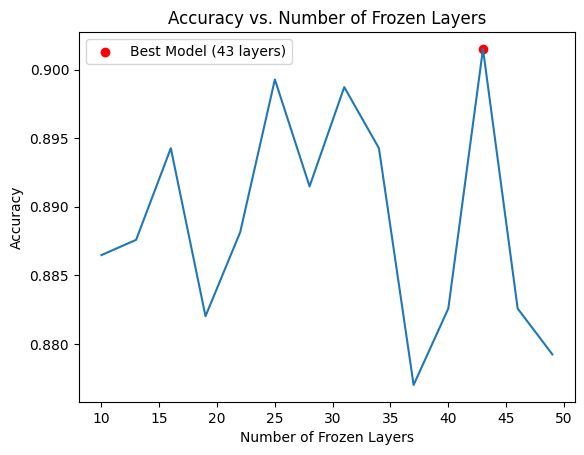

In [11]:
# prompt: visualize accuracy vs. number of frozen layers, and mark the best model

import matplotlib.pyplot as plt

# Assuming 'freeze_layers' and 'ls' are defined from the previous code
plt.plot(freeze_layers, ls)
plt.xlabel("Number of Frozen Layers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Frozen Layers")

# Mark the best model
best_index = ls.index(best_accuracy)
plt.scatter(freeze_layers[best_index], best_accuracy, color='red', label=f'Best Model ({best_frozen_layers} layers)')
plt.legend()
plt.show()

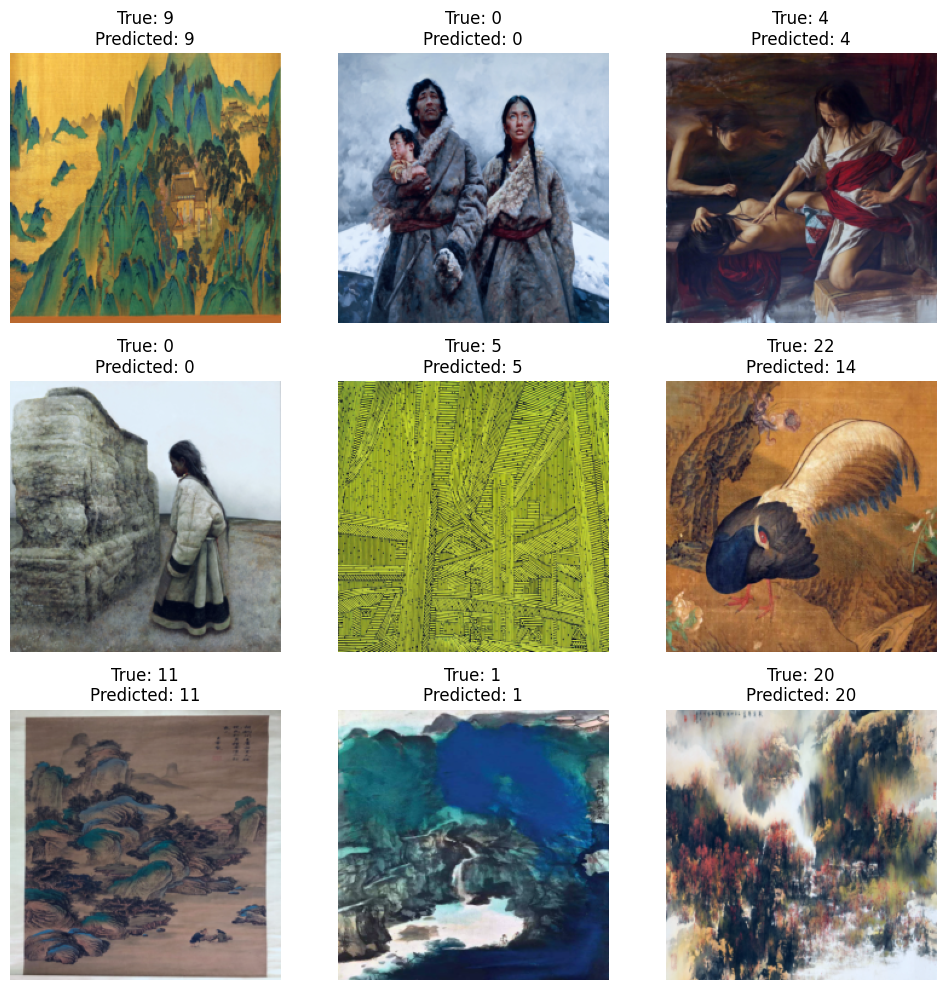

In [12]:
# prompt: use best_model, choose 9 samples from dataset_sample, 3*3, visualize the results including true label and test label

import matplotlib.pyplot as plt
import numpy as np

# Assuming best_model and dataset_sample are defined from the previous code

# Choose 9 random samples
indices = np.random.choice(len(dataset_sample), 9, replace=False)
samples = [dataset_sample[i] for i in indices]

# Make predictions
best_model.eval()
with torch.no_grad():
    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for i, (image, true_label) in enumerate(samples):
        image = image.unsqueeze(0).to(device) # Add batch dimension
        output = best_model(image)
        _, predicted_label = torch.max(output, 1)

        # Get the image tensor back to cpu and convert it to numpy array
        image = image.cpu().squeeze(0).permute(1, 2, 0).numpy()

        # Assuming a normalization is applied to the image, adjust it back to [0, 1]
        image = (image - image.min()) / (image.max() - image.min())

        row = i // 3
        col = i % 3
        axes[row, col].imshow(image)
        axes[row, col].set_title(f"True: {dataset_sample.label_to_idx[list(dataset_sample.label_to_idx.keys())[true_label]]}\nPredicted: {dataset_sample.label_to_idx[list(dataset_sample.label_to_idx.keys())[predicted_label]]}")
        axes[row, col].axis('off')

plt.tight_layout()
plt.show()


In [13]:
# prompt: use best_model, to predict the dataset_sample and calculate the accuracy

# Assuming best_model and dataset_sample are defined from the previous code

# Evaluate the best model on the dataset_sample
best_model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in dataloader_sample:  # Use dataloader_sample
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = best_model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy on dataset_sample: {accuracy}")


Accuracy on dataset_sample: 0.8585858585858586
